In [382]:
import scipy.stats as staty
import numpy.linalg as LA
import numpy as np
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
temp_lj = pd.read_csv('Temp_LJ.csv')
temp_lj

,LETO,MESEC,TEMPERATURA
0,1986,1,0.1
1,1986,2,-2.8
2,1986,3,3.2
3,1986,4,10.2
4,1986,5,17.6
...,...,...,...
415,2020,8,22.2
416,2020,9,17.5
417,2020,10,11.9
418,2020,11,5.3


V datoteki Temp LJ se nahajajo izmerjene mesečne temperature v Ljubljani v 
letih od 1986 do 2020. Postavimo naslednja dva modela spreminjanja temperature
s časom: 

    - Model A: vključuje linearni trend in sinusno nihanje s periodo eno 
        leto.
    - Model B: vključuje linearni trend in spreminjanje temperature za 
        vsak mesec posebej.

([<matplotlib.axis.XTick at 0x1ad300f9250>,
 [Text(0, 0, '1986'),
  Text(60, 0, '1991'),
  Text(120, 0, '1996'),
  Text(180, 0, '2001'),
  Text(240, 0, '2006'),
  Text(300, 0, '2011'),
  Text(360, 0, '2016')])

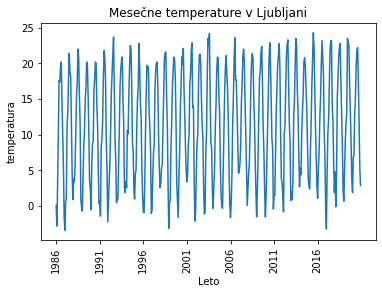

In [410]:
leta = temp_lj["LETO"].values
plt.plot(temp_lj['TEMPERATURA'])
plt.title('Mesečne temperature v Ljubljani')
plt.xlabel('Leto')
plt.ylabel('temperatura')
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')

Text(0, 0.5, 'temperatura')

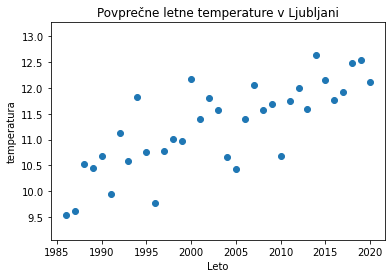

In [411]:
T = temp_lj['TEMPERATURA']
cas = temp_lj["LETO"]
leta = [cas[i] for i in range(420) if i % 12 == 0]
casPlot = np.array(leta)
T_leta = np.array([np.average(T[k*12:(k+1)*12]) for k in range(35)])
Tplot = np.array(T_leta)
plt.scatter(casPlot, Tplot)
plt.ylim(min(Tplot)*0.95, 1.05*max(Tplot))
plt.title('Povprečne letne temperature v Ljubljani')
plt.xlabel('Leto')
plt.ylabel('temperatura')

0.06463585434173644, -118.20894957983138


Text(0, 0.5, 'temperatura')

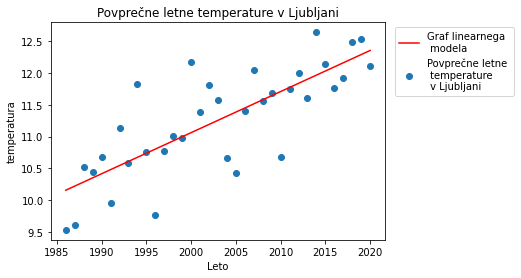

In [414]:
A = np.vstack([leta, np.ones(len(leta))]).T
result = LA.lstsq(A, T_leta, rcond=None)
k, n = result[0]
print(str(k) +', ' + str(n))
premica = [leta[i]*k + n for i in range(len(leta))]
plt.scatter(casPlot, Tplot, label='Povprečne letne \n temperature \n v Ljubljani')
plt.plot(casPlot, premica, 'r', label='Graf linearnega \n modela')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))
plt.title('Povprečne letne temperature v Ljubljani')
plt.xlabel('Leto')
plt.ylabel('temperatura')

In [386]:
std_L = np.sqrt(result[1]/(35-2))
std_L

array([0.53218307])

Text(0, 0.5, 'Število rezidualov')

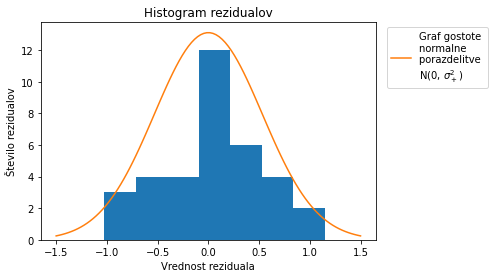

In [423]:
residual = T_leta - premica
z, xbins, _ = plt.hist(residual, bins=7)
x = np.linspace(-1.5, 1.5, 100)
plt.plot(x,17.5*staty.norm.pdf(x,0,std_L), label='Graf gostote \nnormalne \nporazdelitve \nN(0, $\sigma_+^2$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
plt.title('Histogram rezidualov')
plt.xlabel('Vrednost reziduala')
plt.ylabel('Število rezidualov')

Text(0, 0.5, 'Vrednost reziduala')

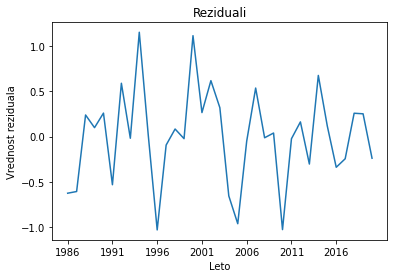

In [388]:
#plt.plot(residual)
leta = temp_lj["LETO"].values
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
default_x_ticks = range(len(years5))
plt.plot(np.arange(35), residual)
plt.xticks(np.arange(0,35,5), years5)
plt.title('Reziduali')
plt.xlabel('Leto')
plt.ylabel('Vrednost reziduala')


a) Preizkusite model A znotraj modela B.

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big)$$

Text(0, 0.5, 'temperatura')

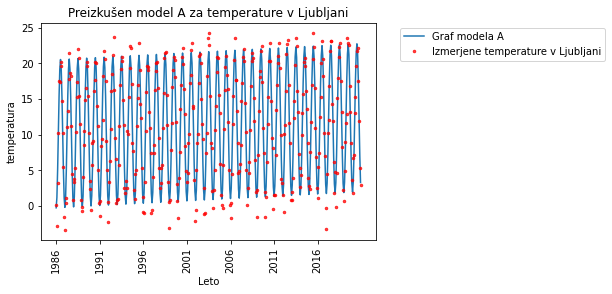

In [389]:
L = 420
leta = np.array([1986 + i//12 for i in range(L)])
leta = temp_lj["LETO"].values
enice = np.ones(L)
meseci = np.array([(1 + i%12) for i in range (L)])
sin_meseci = np.sin(meseci*np.pi/6)
cos_meseci = np.cos(meseci*np.pi/6)
M = np.array([leta,
             enice,
             sin_meseci,
             cos_meseci])
temperature = np.array(temp_lj['TEMPERATURA'])
result = LA.lstsq(M.T, temperature, rcond=None)

a, b, c, d = result[0]
model_A = [a*leta[l] + b + c*sin_meseci[l] + d*cos_meseci[l] for l in range(L)]
plt.plot(np.arange(420), model_A, label='Graf modela A')
plt.plot(np.arange(420), temperature, 'ro', markersize=2.5, alpha=0.75, label='Izmerjene temperature v Ljubljani')
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
plt.title('Preizkušen model A za temperature v Ljubljani')
plt.xlabel('Leto')
plt.ylabel('temperatura')

Text(0.5, 0, 'Vrednost reziduala')

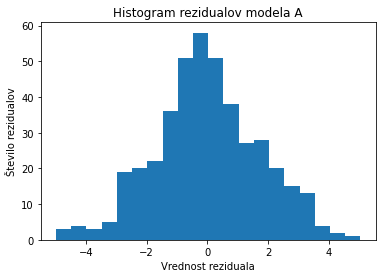

In [390]:
residual = temperature - model_A
z, xbins, _ = plt.hist(residual, bins=20)
plt.title('Histogram rezidualov modela A')
plt.ylabel('Število rezidualov')
plt.xlabel('Vrednost reziduala')

Text(0, 0.5, 'Vrednost reziduala')

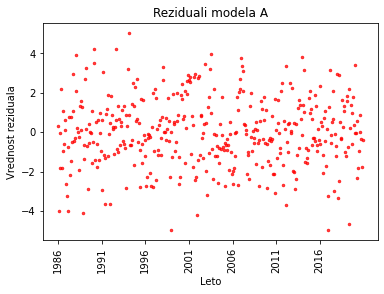

In [391]:
plt.plot(residual, 'ro', markersize=2.5, alpha=0.75)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
plt.title('Reziduali modela A')
plt.xlabel('Leto')
plt.ylabel('Vrednost reziduala')

In [392]:
a - 0.06463585434173644

-4.066191827689636e-15

Ocenimo še varianco oz. standardni odklon napake $\epsilon$.

In [393]:
std_A = np.sqrt(result[1]/(L-4))
std_A

array([1.73922435])

Text(0.5, 0, 'Vrednost reziduala')

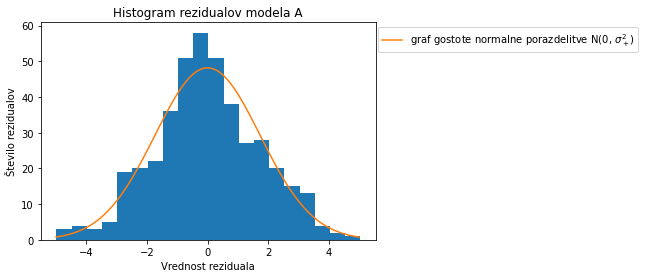

In [394]:
residual = temperature - model_A
z, xbins, _ = plt.hist(residual, bins=20)
x = np.linspace(-5, 5, 100)
plt.plot(x,210*staty.norm.pdf(x,0,std_A), label='graf gostote normalne porazdelitve N(0, $\sigma_+^2$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1.0))
plt.title('Histogram rezidualov modela A')
plt.ylabel('Število rezidualov')
plt.xlabel('Vrednost reziduala')


Najprej bomo preverili linearni model

$$X_{ij} = a \cdot i + b$$

znotraj modela

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big)$$

torej preverili bomo s fischerjevim testom za p = 4, q = 2, n = 420.

Fischerjev test:

$$ F = \frac{\frac{RSS_W - RSS_V}{p-q}}{\frac{RSS_V}{n-p}} $$

kjer je $RSS$ vsota kvadratov rezidualov, W in V pa 2 in 4 dimenzionalna podprostora.

&H_0 : v \in W& in alternativna domneva $H_1 : v \notin W$. Če je 

$$F \geq F^{-1}_{Fischer(p-q, n-p)}(1-\alpha) $$

začetno domnevo $H_0$ zavrnemo, sicer pa sprejmemo.
Poračunajmo residuale:

In [395]:
p = 4
q = 2
alpha = 0.05
n = len(M[0])
resultV = LA.lstsq(M.T, temperature, rcond=None)
resultW = LA.lstsq(M[0:2].T, temperature, rcond=None)
RSS_V = float(resultV[1])
RSS_W = float(resultW[1])
F = (RSS_W - RSS_V)*(n-p)/((p-q)*RSS_V)
f = staty.f.isf(alpha, n-p, p-q)
F, f, F < f

(3748.2703085236194, 19.4933219988683, False)

In [396]:
aic_L = 2 + 420*np.log(RSS_W)
aic_L

4236.89472273255

Text(0, 0.5, 'temperatura')

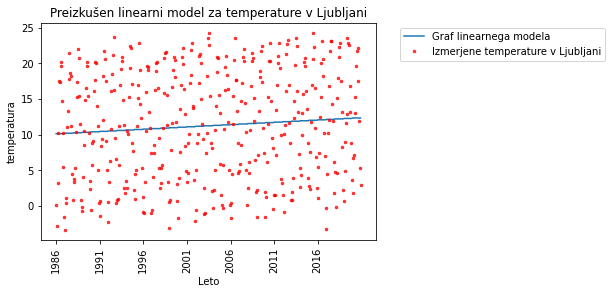

In [397]:
w1, w2 = resultW[0]
model_W = [w1*leta[l] + w2 for l in range(L)]
plt.plot(np.arange(420), model_W, label='Graf linearnega modela')
plt.plot(np.arange(420), temperature, 'ro', markersize=2.5, alpha=0.75, label='Izmerjene temperature v Ljubljani')
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
plt.title('Preizkušen linearni model za temperature v Ljubljani')
plt.xlabel('Leto')
plt.ylabel('temperatura')

Text(0.5, 0, 'Vrednost reziduala')

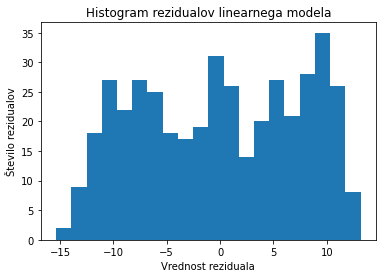

In [398]:
residual_W = temperature - model_W
z, xbins, _ = plt.hist(residual_W, bins=20)
plt.title('Histogram rezidualov linearnega modela')
plt.ylabel('Število rezidualov')
plt.xlabel('Vrednost reziduala')

Text(0, 0.5, 'Vrednost reziduala')

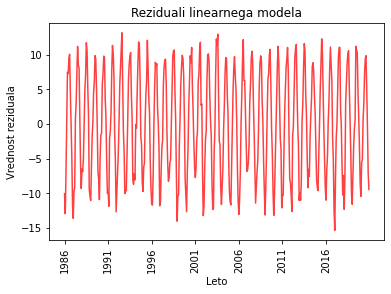

In [399]:
plt.plot(residual_W,'r', markersize=2.5, alpha=0.75)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
plt.title('Reziduali linearnega modela')
plt.xlabel('Leto')
plt.ylabel('Vrednost reziduala')

Text(0, 0.5, 'Vrednost reziduala')

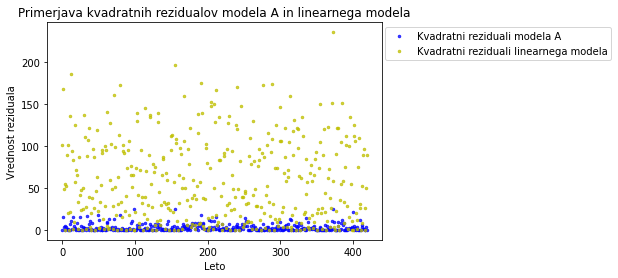

In [400]:
residuali_V = (temperature - model_A)**2
residuali_W = (temperature - model_W)**2
plt.plot(residuali_V, 'bo', markersize=2.5, alpha=0.75, label='Kvadratni reziduali modela A')
plt.plot(residuali_W, 'yo', markersize=2.5, alpha=0.75, label='Kvadratni reziduali linearnega modela')
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title('Primerjava kvadratnih rezidualov modela A in linearnega modela')
plt.xlabel('Leto')
plt.ylabel('Vrednost reziduala')

Vzemimo zdaj za ožji model model A:

$$ X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big) $$

pri modelu B pa dodamo neke random parametre

$$X_{ij} = a \cdot i + b + c \cdot \sin \Big(\frac{2\pi j}{12}\Big) + d \cdot \cos \Big(\frac{2\pi j}{12}\Big) + 
e \cdot j$$

In [401]:
sez = [i for i in range(1, 421)]
sez2 = [i^2 for i in range(1, 421)]

M_1 = np.array([
             leta,
             enice,
             sin_meseci,
             cos_meseci,
             sez,
             sez2
])
p = 6
q = 4
alpha = 0.05
n = len(M[0])
resultV = LA.lstsq(M_1.T, temperature, rcond=None)
resultW = LA.lstsq(M.T, temperature, rcond=None)
RSS_V = resultV[1]
RSS_W = resultW[1]
F = (RSS_W - RSS_V)*(n-p)/((p-q)*RSS_V)
f = staty.f.isf(alpha, n-p, p-q)
F, f, F < f

(array([4.67718082]), 19.493310387042452, array([ True]))

In [402]:
aic_A = 4 + L*np.log(RSS_W)
aic_B = 6 + L*np.log(RSS_V)
aic_A, aic_B, aic_L

(array([3001.77676816]), array([2994.39246083]), 4236.89472273255)

Text(0, 0.5, 'temperatura')

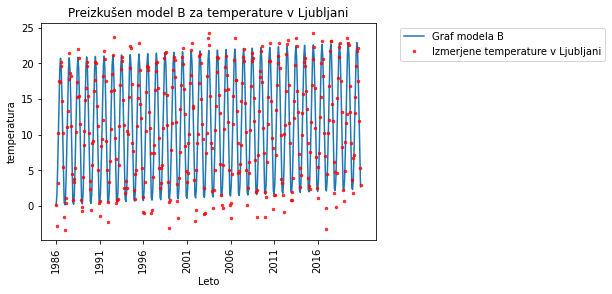

In [403]:
a, b, c, d, e, f = resultV[0]
model_B = [a*leta[l] + b + c*sin_meseci[l] + d*cos_meseci[l] + e*sez[l] + f*sez2[l] for l in range(L)]
plt.plot(np.arange(420), model_B, label='Graf modela B')
plt.plot(np.arange(420), temperature, 'ro', markersize=2.5, alpha=0.75, label='Izmerjene temperature v Ljubljani')
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
plt.title('Preizkušen model B za temperature v Ljubljani')
plt.xlabel('Leto')
plt.ylabel('temperatura')

Text(0.5, 0, 'Vrednost reziduala')

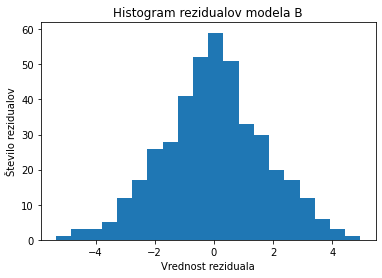

In [404]:
residual = temperature - model_B
z, xbins, _ = plt.hist(residual, bins=20)
plt.title('Histogram rezidualov modela B')
plt.ylabel('Število rezidualov')
plt.xlabel('Vrednost reziduala')

Text(0, 0.5, 'Vrednost reziduala')

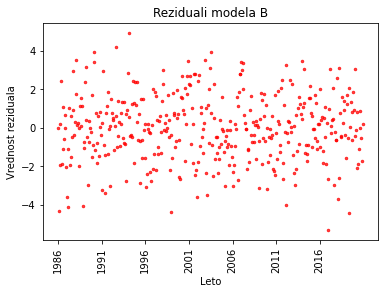

In [405]:
plt.plot(residual, 'ro', markersize=2.5, alpha=0.75)
years = list(set(leta))
years5 = [years[i] for i in range(35) if i % 5 == 0]
plt.xticks(np.arange(0,420,420//7), years5, rotation='vertical')
plt.title('Reziduali modela B')
plt.xlabel('Leto')
plt.ylabel('Vrednost reziduala')

In [406]:
std_B = np.sqrt(resultV[1]/(L-p))
std_B - std_A

array([-0.01517278])

420

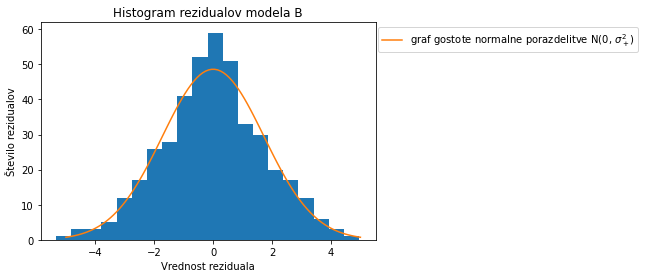

In [407]:
residual = temperature - model_B
z, xbins, _ = plt.hist(residual, bins=20, label='')
x = np.linspace(-5, 5, 100)
plt.plot(x,210*staty.norm.pdf(x,0,std_B), label='graf gostote normalne porazdelitve N(0, $\sigma_+^2$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1.0))
plt.title('Histogram rezidualov modela B')
plt.ylabel('Število rezidualov')
plt.xlabel('Vrednost reziduala')
len(residual)

Text(0, 0.5, 'Vrednost reziduala')

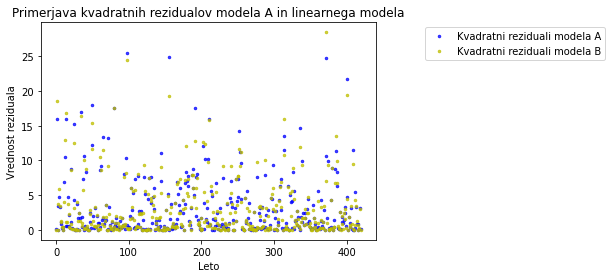

In [408]:
residuali_A = (temperature - model_A)**2
residuali_B = (temperature - model_B)**2
plt.plot(residuali_A, 'bo', markersize=2.5, alpha=0.75, label='Kvadratni reziduali modela A')
plt.plot(residuali_B, 'yo', markersize=2.5, alpha=0.75, label='Kvadratni reziduali modela B')
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title('Primerjava kvadratnih rezidualov modela A in linearnega modela')
plt.xlabel('Leto')
plt.ylabel('Vrednost reziduala')

b) Pri modeliranju je nevarno privzeti preširok model: lahko bi recimo postavili
model, po katerem je temperatura vsak mesec drugačna, neidvisno od ostalih
mesecev, a tak model bi bil neuporaben za napovedovanje. Akaikejeva 
informacija nam pomaga poiskati optimalni model – izberemo tistega, za katerega
je le-ta najmanjša. Akaikejeva informacija je sicer definirana z verjetjem, 
a pri linearni regresiji in Gaussovem modelu je le-ta ekvivalentna naslednji 
modifikaciji:  
$$\text{AIC} := 2m + n \ln \text{RSS,}
$$
kjer je m število parametrov, n pa je število opažanj. Kateri od zgornjih dveh
modelov ima manjšo Akaikejevo informacijo?